In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.final_model_loss_train_combine_fine import *
from model.final_model.final_model_combine import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.plot import *
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [3]:
from torch.utils.data import Subset


train_loader = DataLoader( dataset_train,batch_size=32,shuffle=False,collate_fn=collate_fn )

batch = next(iter(train_loader))
*_, original_indices = batch
small_ids = original_indices.tolist()

small_subset = Subset(dataset_train, small_ids)

small_train_loader = DataLoader(
    small_subset,
    batch_size=len(small_ids),
    shuffle=True,
    collate_fn=collate_fn
)
small_train_loader_p = DataLoader(
    small_subset,
    batch_size=len(small_ids),
    shuffle=False,
    collate_fn=collate_fn
)

In [4]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [5]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_v2/combine_30_fine_freeze_som"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_v2/combine_30_fine_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader,device, optimizer,  epochs=100, save_dir=save_path,
            patience =50)

[Joint] Early stopping at epoch 57 due to no improvement for 50 epochs.
[Joint] Loading best model weights.


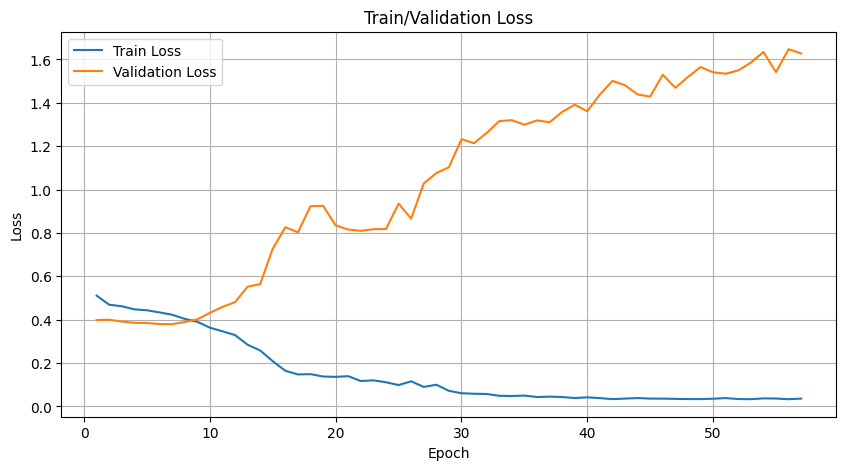

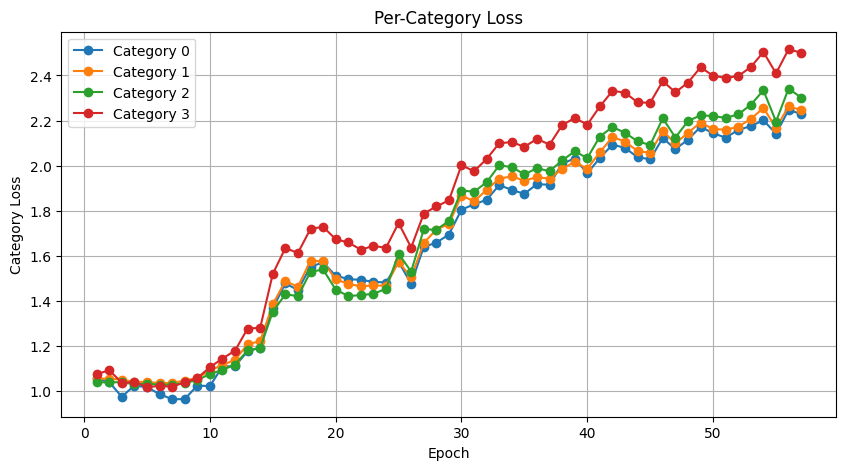

In [6]:
plot_training_history(history)

In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_v2/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

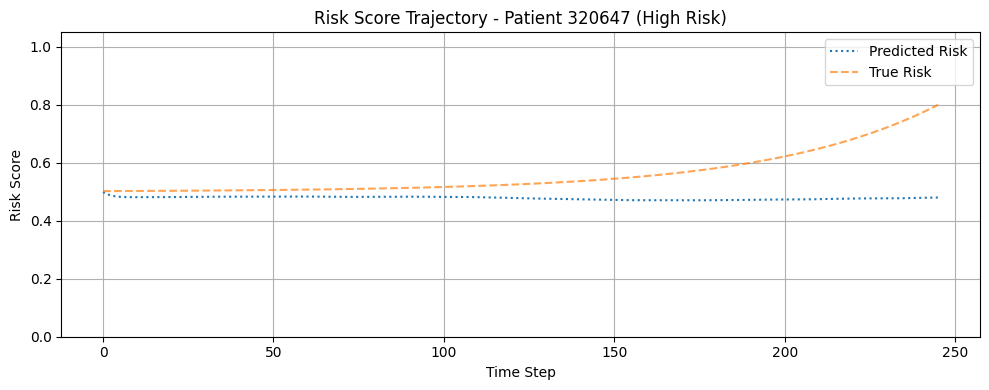

In [7]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

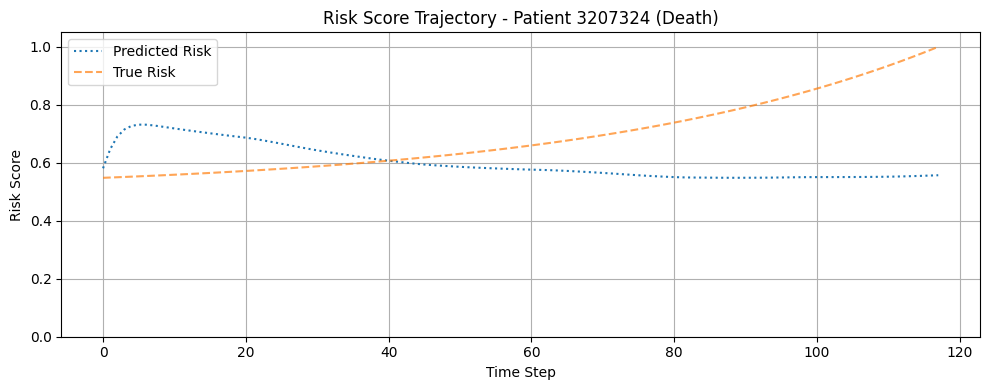

In [8]:
plot_patient_risk_score(model, test_loader, patient_index=400, device=device)

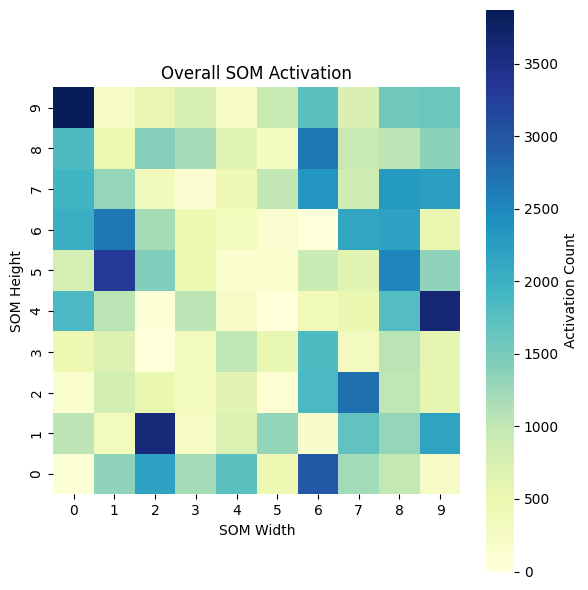

In [9]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


--> Heatmap computation complete.


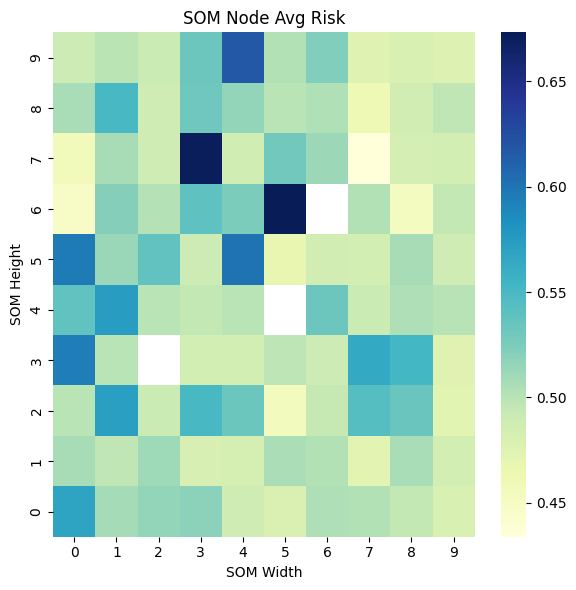

In [10]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


--> Heatmap computation complete.
--- Searching for specified patient IDs: ['320647', '3207324'] ---


Searching for patients:  80%|████████  | 12/15 [00:18<00:04,  1.55s/it]

  -> Found 2 target(s) in current batch. Running forward pass...


Searching for patients:  80%|████████  | 12/15 [00:21<00:05,  1.81s/it]

    -> Computed trajectory for Patient ID: 320647 (Category: 2)
    -> Computed trajectory for Patient ID: 3207324 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [0, 61, 123, 184, 245]



/home/mei/nas/docker/thesis/model_train/model/final_model/plot.py:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


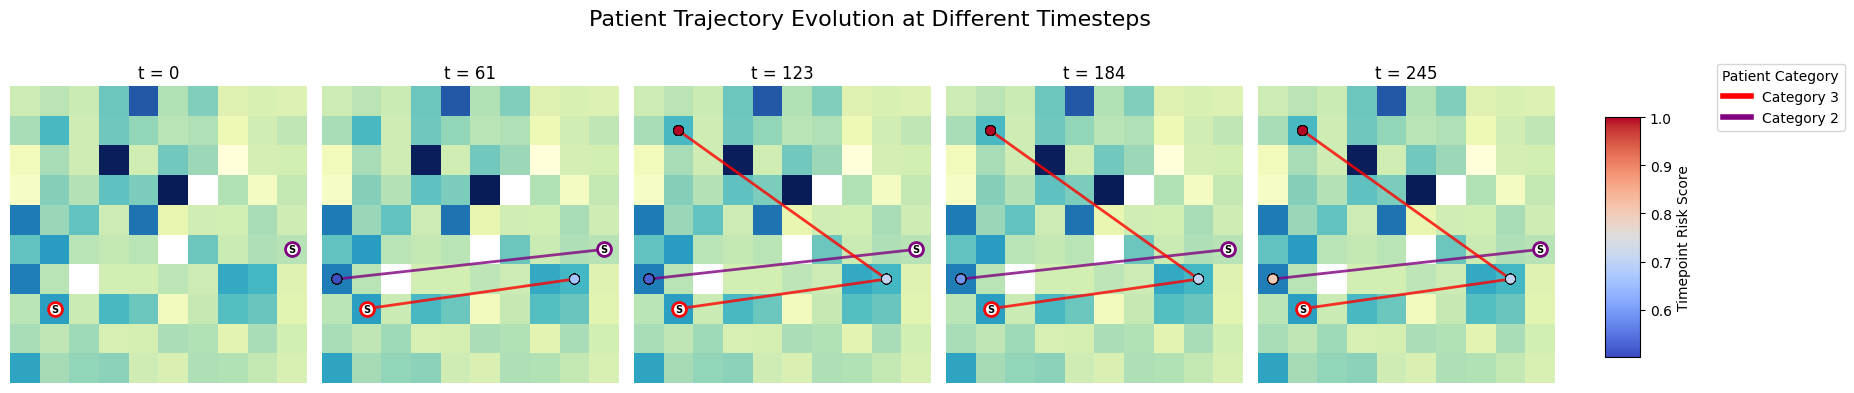

In [11]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

# --- 2. 计算目标病人的轨迹 ---
patient_ids = ['320647', '3207324'] 

targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    0, 
    max_len // 4, 
    max_len // 2, 
    max_len * 3 // 4, 
    max_len - 1 
]
snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)